In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk


nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\predator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation

In [2]:
data_path = "data/all-data.csv"
headers = ["sentiment", "content"]
df = pd.read_csv(data_path, names=headers, encoding="ISO-8859-1")
print(df.shape)
df.head()

(4846, 2)


,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
classes = {
    class_name: idx for idx, class_name in enumerate(df["sentiment"].unique().tolist())
}
df["sentiment"] = df["sentiment"].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


## Text normalization

In [4]:
english_stop_words = stopwords.words("english")
stemmer = PorterStemmer()


def text_normalize(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r"[^\w\s]", "", text)
    text = " ".join(
        [word for word in text.split(" ") if word not in english_stop_words]
    )
    text = " ".join([stemmer.stem(word) for word in text.split(" ")])
    return text

In [5]:
df["content"] = df["content"].apply(lambda x: text_normalize(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


## Build dictionary

In [6]:
vocab = []
for sentence in df["content"].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append("UNK")
vocab.append("PAD")
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)


def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx["UNK"]
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx["PAD"]] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

## Train, val, test split

In [7]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df["content"].tolist()
labels = df["sentiment"].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=val_size, random_state=seed, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed, shuffle=is_shuffle
)

## Create Dataset, Dataloader

In [8]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)
        text = torch.tensor(text)
        label = torch.tensor(label)

        return text, label

In [9]:
max_seq_len = 32
train_dataset = FinancialNews(
    X_train,
    y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform,
)
val_dataset = FinancialNews(
    X_val, y_val, word_to_idx=word_to_idx, max_seq_len=max_seq_len, transform=transform
)
test_dataset = FinancialNews(
    X_test,
    y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform,
)

In [10]:
train_batch_size = 128
val_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)

# Modeling

In [11]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob
    ):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [12]:
n_classes = len(set(y_train))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob,
).to(device)

model

cuda


SentimentClassifier(
  (embedding): Embedding(8913, 64)
  (rnn): RNN(64, 64, num_layers=2, batch_first=True)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)

In [13]:
# summary model
from torchsummary import summary

summary(model, input_size=(max_seq_len,))

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         570,432
├─RNN: 1-2                               16,640
├─LayerNorm: 1-3                         128
├─Dropout: 1-4                           --
├─Linear: 1-5                            1,040
├─ReLU: 1-6                              --
├─Linear: 1-7                            51
Total params: 588,291
Trainable params: 588,291
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         570,432
├─RNN: 1-2                               16,640
├─LayerNorm: 1-3                         128
├─Dropout: 1-4                           --
├─Linear: 1-5                            1,040
├─ReLU: 1-6                              --
├─Linear: 1-7                            51
Total params: 588,291
Trainable params: 588,291
Non-trainable params: 0

# Training

In [14]:
lr = 1e-4
n_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss = sum(losses) / len(losses)
        acc = correct / total

    return loss, acc

In [16]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}"
        )

    return train_losses, val_losses

In [17]:
train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, device, n_epochs
)

EPOCH 1:	Train loss: 1.0506	Val loss: 1.0035
EPOCH 2:	Train loss: 0.9855	Val loss: 0.9678
EPOCH 3:	Train loss: 0.9568	Val loss: 0.9476
EPOCH 4:	Train loss: 0.9404	Val loss: 0.9305
EPOCH 5:	Train loss: 0.9317	Val loss: 0.9291
EPOCH 6:	Train loss: 0.9274	Val loss: 0.9290
EPOCH 7:	Train loss: 0.9293	Val loss: 0.9290
EPOCH 8:	Train loss: 0.9316	Val loss: 0.9289
EPOCH 9:	Train loss: 0.9300	Val loss: 0.9289
EPOCH 10:	Train loss: 0.9298	Val loss: 0.9288
EPOCH 11:	Train loss: 0.9296	Val loss: 0.9288
EPOCH 12:	Train loss: 0.9326	Val loss: 0.9289
EPOCH 13:	Train loss: 0.9281	Val loss: 0.9288
EPOCH 14:	Train loss: 0.9296	Val loss: 0.9288
EPOCH 15:	Train loss: 0.9287	Val loss: 0.9287
EPOCH 16:	Train loss: 0.9285	Val loss: 0.9287
EPOCH 17:	Train loss: 0.9278	Val loss: 0.9286
EPOCH 18:	Train loss: 0.9298	Val loss: 0.9285
EPOCH 19:	Train loss: 0.9309	Val loss: 0.9285
EPOCH 20:	Train loss: 0.9281	Val loss: 0.9286
EPOCH 21:	Train loss: 0.9291	Val loss: 0.9286
EPOCH 22:	Train loss: 0.9288	Val loss: 0.92

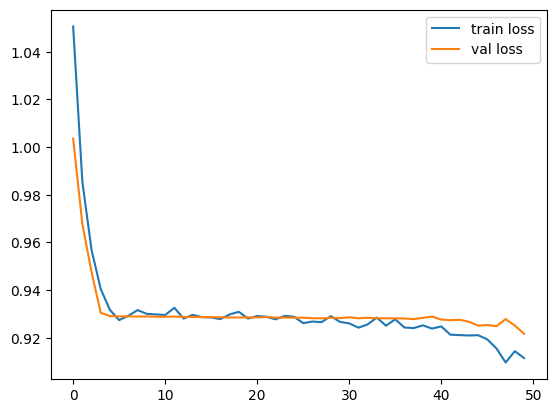

In [18]:
# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [19]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val accuracy:", val_acc)
print("Test accuracy:", test_acc)

Evaluation on val/test dataset
Val accuracy: 0.5948453608247423
Test accuracy: 0.6164948453608248
